In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import fastai.callbacks.hooks

In [22]:
path = Path("UCMerced_LandUse")

In [23]:
src = (ImageItemList.from_folder(path)
        .random_split_by_pct(0.2)
        .label_from_folder())

In [43]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = src.transform(tfms,size=128).databunch(bs=16,num_workers=0).normalize(imagenet_stats)

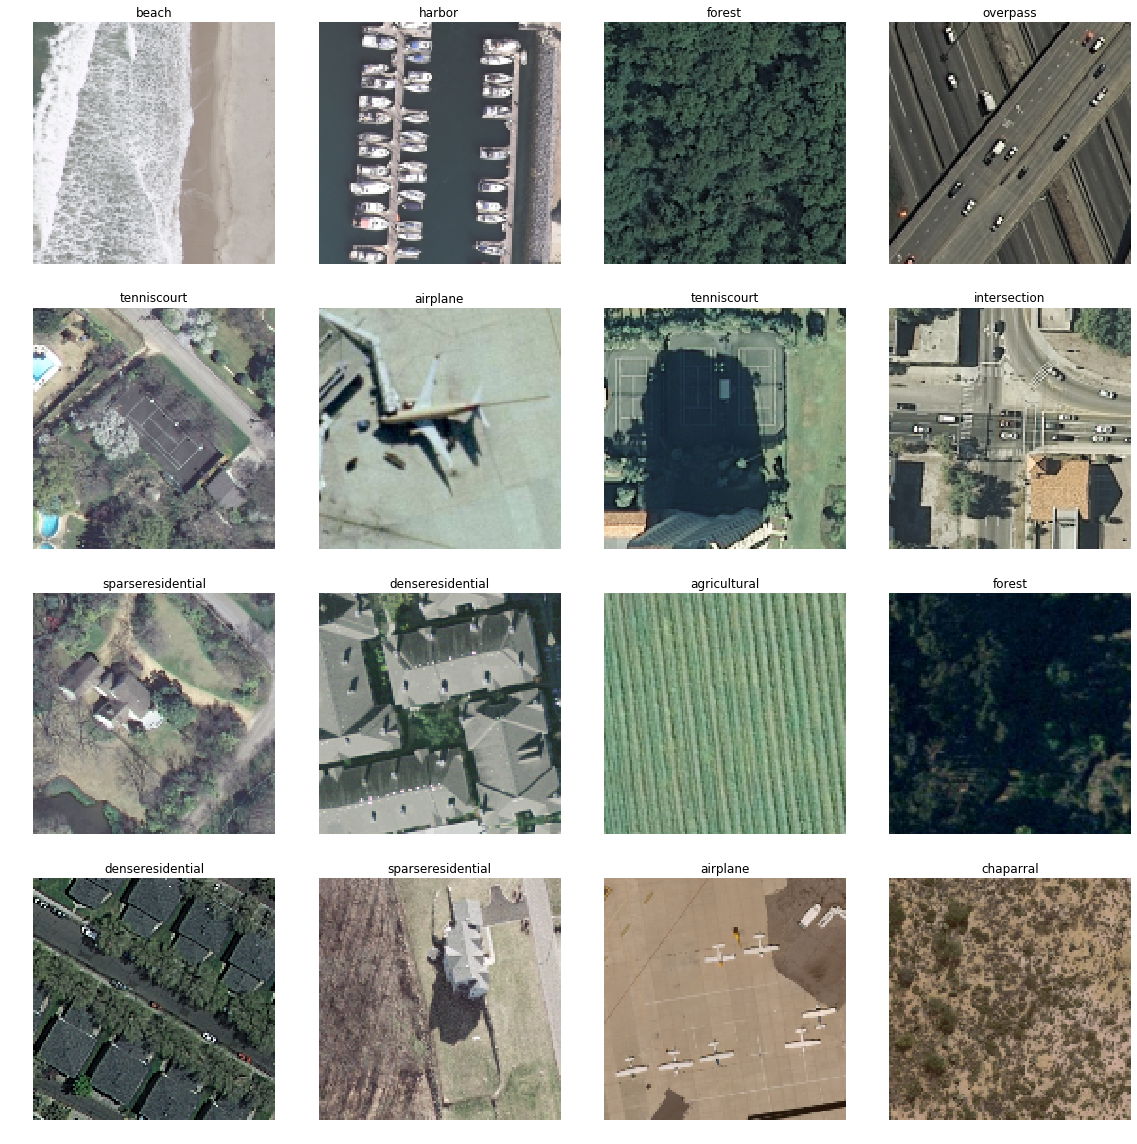

In [44]:
data.show_batch()

In [27]:
class SidekickAlexNet(nn.Module):
    def __init__(self, num_classes=1000,width=8,pretrained=True):
        super().__init__()
        
        self.hero = create_body(models.alexnet,pretrained=pretrained)
        ml = [f for i,f in enumerate(next(self.hero.children()).children()) if i in [2,5,7,9,12]]
        self.hooks = fastai.callbacks.Hooks(ml,lambda m,i,o: o,detach=False)
        
        self.features = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(3, 8*width, kernel_size=11, stride=4, padding=2),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(nn.Conv2d(8*width + 64, 24 * width, kernel_size=5, padding=2),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(nn.Conv2d(24*width + 192, 48 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(48*width + 384, 32 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(32*width + 256, 32 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2))])
        
        self.classifier = create_head((32*width + 256)*2,num_classes)

    def forward(self, x):
        bs = x.shape[0]
        pt = self.hero(x)
        
        x = self.features[0](x)
        for f, a in zip(self.features[1:],self.hooks.stored):
            x = f(torch.cat([x,a],dim=1))
            
        x = torch.cat([x,pt],dim=1)    
        x = self.classifier(x)
        return x


In [28]:
learn = create_cnn(data,models.alexnet,metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02


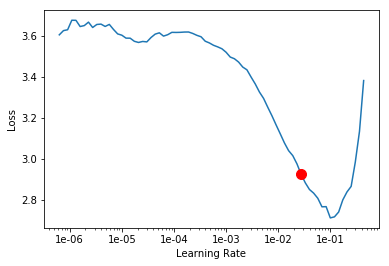

In [44]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.freeze()

In [30]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.637127,0.709796,0.802381
2,0.977926,0.545158,0.819048
3,0.952534,0.503856,0.838095
4,0.871064,0.418127,0.878571
5,0.791006,0.454304,0.857143
6,0.676531,0.314457,0.890476
7,0.600595,0.295644,0.904762
8,0.501463,0.273977,0.897619
9,0.414845,0.232090,0.926190
10,0.405429,0.236919,0.921429


In [31]:
learn.unfreeze()
learn.fit_one_cycle(20,1e-5)

epoch,train_loss,valid_loss,accuracy
1,0.366463,0.236878,0.921429
2,0.376893,0.225877,0.926190
3,0.376221,0.220031,0.928571
4,0.354602,0.215116,0.935714
5,0.353106,0.206350,0.938095
6,0.358669,0.207837,0.940476
7,0.305047,0.201852,0.945238
8,0.318590,0.196696,0.935714
9,0.350391,0.203257,0.938095
10,0.308862,0.207429,0.930952


In [32]:
max([t[0].item() for t in learn.recorder.metrics])

0.9476190209388733

In [36]:
learnSK = Learner(data,SidekickAlexNet(data.train_ds.c,width=8),metrics=[accuracy])
learnSK.split([learnSK.model.hero,learnSK.model.features[0],learnSK.model.classifier])

In [37]:
learnSK.model(next(iter(data.train_dl))[0]).shape

torch.Size([16, 21])

In [38]:
learnSK.freeze_to(1)

In [39]:
learnSK.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy
1,2.241025,1.711459,0.704762
2,1.396883,0.900594,0.880952
3,0.802953,0.498815,0.904762
4,0.502344,0.390174,0.892857
5,0.413080,0.275350,0.935714
6,0.358194,0.266831,0.926190
7,0.332850,0.235367,0.919048
8,0.273544,0.191099,0.945238
9,0.260640,0.250144,0.926190
10,0.180689,0.233772,0.928571


In [40]:
learnSK.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.035711,0.114718,0.961905
2,0.035979,0.123658,0.957143
3,0.041160,0.119140,0.957143
4,0.029551,0.120708,0.964286
5,0.039883,0.115566,0.969048
6,0.027643,0.118329,0.959524
7,0.023618,0.118564,0.954762
8,0.024057,0.114310,0.959524
9,0.020861,0.114588,0.964286
10,0.029704,0.111191,0.961905


In [36]:
learnSK.save("sz128")

In [18]:
dataL = src.transform(tfms,size=256).databunch(bs=16,num_workers=0).normalize(imagenet_stats)
learnSK.data = dataL

In [19]:
learnSK.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.710316,0.445947,0.869048
2,0.396940,0.252693,0.919048
3,0.240493,0.183020,0.921429
4,0.206263,0.144641,0.945238
5,0.156719,0.149835,0.945238
6,0.144096,0.138308,0.947619
7,0.143466,0.128344,0.942857
8,0.108807,0.125348,0.947619
9,0.115320,0.125757,0.950000
10,0.116474,0.126439,0.947619
